# Проверка базовой теории

Подключаем необходимые библиотеки для обработки изображений

In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

$L^p$ метрика для изображений (в качестве p выступает переменная param)

In [2]:
def metric(img_fir, img_sec, param = 1):
  if img_fir.shape != img_sec.shape:
    return None
  height, width = img_fir.shape
  res = 0
  for x in range(width):
    for y in range(height):
      res += np.abs((int(img_fir[y, x]) - int(img_sec[y, x])) / 255) ** param
  return (res / (height * width)) ** (1 / param)

Операция пулинга с размерами окна pool_height и pool_width и агрегирующей функцией aggr_func

In [3]:
def pooling(img, pool_height, pool_width, aggr_func = np.average):

  #размеры изображений и число окон в пуллинге по каждой оси

  height, width = img.shape
  pooled_img = np.full((height, width), 0)
  num_x = int(height / pool_height)
  num_y = int(width / pool_width)

  #заполнение массива pooled_img

  for i in range(num_x):
    for j in range(num_y):
      value = aggr_func(img[i * pool_height : (i + 1) * pool_height, j * pool_width : (j + 1) * pool_width])
      pooled_img[i * pool_height : (i + 1) * pool_height, j * pool_width : (j + 1) * pool_width] = value
    if (num_y * pool_width != width):
      value = aggr_func(img[i * pool_height : (i + 1) * pool_height, num_y * pool_width : width])
      pooled_img[i * pool_height : (i + 1) * pool_height, num_y * pool_width : width] = value

  if (num_x * pool_height != height):
    for j in range(num_y):
      value = aggr_func(img[num_x * pool_height : height, j * pool_width : (j + 1) * pool_width])
      pooled_img[num_x * pool_height : height, j * pool_width : (j + 1) * pool_width] = value
    if (num_y * pool_width != width):
      value = aggr_func(img[num_x * pool_height : height, num_y * pool_width : width])
      pooled_img[num_x * pool_height : height, num_y * pool_width : width] = value

  return pooled_img.astype(np.uint8)

Индекс структурированности $\text{IND}(I, k)$

In [4]:
def index(img, pool_k, param):
  pld = pooling(img, pool_k, pool_k)
  return metric(pld, img, param)

Зафиксируем размер метрики $p = 1$ и вычислим индекс структурированности для изображений из условия задачи (размеры окна пулинга $k = 2 \div 10$).

In [5]:
#теоретическое значения индекса для шума

def noise_index(param):
  lb = 0
  for i in range(128):
    lb += np.float_power(127.5 - i, param)
  return np.float_power(lb / 128, 1 / param) / 255

#график величины индекса в зависимости от размера окна k

def indexing_with_constant_param(max_pool_size, param, *args):
  plt.grid(visible=True, linewidth=0.6)
  i = 0
  for img in args:
    pld_metric = [0]
    for k in range(2, max_pool_size + 1):
      pld_metric.append(index(img, k, param))
    area = [60] * max_pool_size
    plt.plot(range(1, max_pool_size + 1), pld_metric, label = i + 1)
    i += 1
  nlb = noise_index(param)
  plt.plot(range(1, max_pool_size + 1), [nlb] * max_pool_size, label = r'теоретический индекс шума')
  plt.ylabel(r'$IND, \; p = $' + str(param), fontsize = 12)
  plt.xlabel(r'$k$', fontsize = 12)
  plt.legend()
  plt.show()

Загружаем необходимые изображения из диска и строим график

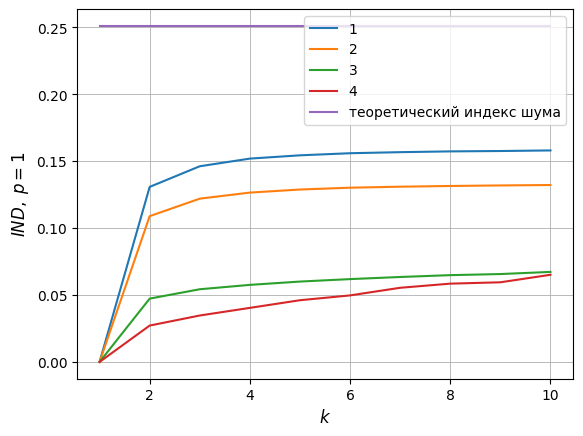

In [6]:
img1 = cv2.imread("/content/drive/MyDrive/ittp/ittp_example_1.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/content/drive/MyDrive/ittp/ittp_example_2.png", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("/content/drive/MyDrive/ittp/ittp_example_3.png", cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread("/content/drive/MyDrive/ittp/ittp_example_4.png", cv2.IMREAD_GRAYSCALE)

indexing_with_constant_param(10, 1, img1, img2, img3, img4)

# Проверка утверждения об индексе шума

Напишем функцию, генерирующую шум согласно определению

In [7]:
def generate_noise(height, width):
  out = np.zeros((height, width))
  for i in range(height):
    for j in range(width):
      q = random.randint(0, 255)
      out[i, j] = q
  return out.astype(np.uint8)

Построим график зависимости индекса сгенерированного шума от параметра метрики

In [8]:
def check_noise_index(max_param):

  #теоретическое значение шума

  metric_param = np.arange(1, max_param, 0.01)
  theory_index = []
  for p in metric_param:
    theory_index.append(noise_index(p))

  #вычисление индекса по формуле

  out = generate_noise(100, 100)
  for pool_k in range(1, 6):
    noise_lst = np.zeros(max_param)
    for p in range(1, max_param + 1):
      noise_lst[p - 1] = index(out, pool_k * 10, p)
    plt.scatter(range(1, max_param + 1), noise_lst, color = 'r', marker = '+')

  #строим график

  plt.grid(visible=True, linewidth=0.6)
  plt.plot(metric_param, theory_index, '--', label = r'N-IND(p)')
  plt.ylabel(r'$IND$', fontsize = 12)
  plt.xlabel(r'$p$', fontsize = 12)
  plt.legend()
  plt.show()

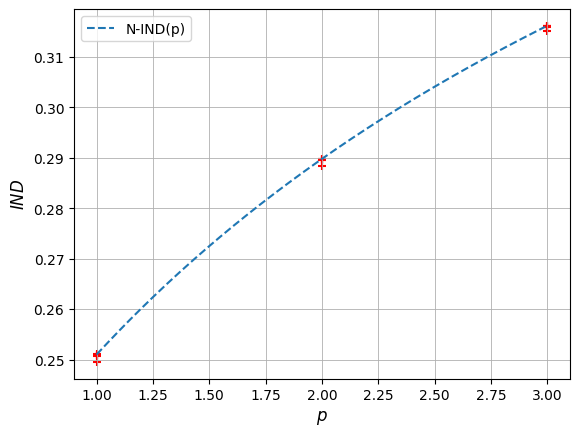

In [9]:
check_noise_index(3)

# Проверка теоремы о двухцветном изображении

Проверим теорему о двухцветном изображении. Для этого напишем функцию, зашумляющую изображение согласно определению:

In [10]:
#генерирует шум (img --- двухцветное) с вероятностью param (в процентах)

def generate_noised_image(img, param):
  height, width = img.shape
  out = np.zeros(img.shape)
  for i in range(height):
    for j in range(width):
      p = random.randint(1, 100)
      if (p <= param):
        out[i, j] = img[i, j]
      else:
        out[i, j] = 255 - img[i, j]
  return out.astype(np.uint8)

Загружаем двухцветное изображение, проводим для него зашумление при $p = 1 \div 100  \: \%$ и откладываем на графике: по оси $x \; -$  процент зашумления $p$, по оси $y \; -$ индекс.

In [11]:
def index_2color_noise(img, pool_k, metric_param = 1):

  #индекс исходного изображения

  ind = index(img, pool_k, metric_param)

  #индекс зашумленного изображения

  noise_lst = []
  for p in range(0, 101):
    ns = generate_noised_image(img, p)
    noise_lst.append(index(ns, pool_k, metric_param))

  #строим график

  plt.grid(visible=True, linewidth=0.6)
  plt.plot(range(0, 101), [ind] * 101, label = r'IND(I, k)')
  plt.scatter(range(0, 101), noise_lst, color = 'r', marker = '+')
  plt.ylabel(r'$IND$', fontsize = 12)
  plt.xlabel(r'$p$', fontsize = 12)
  plt.legend()
  plt.show()

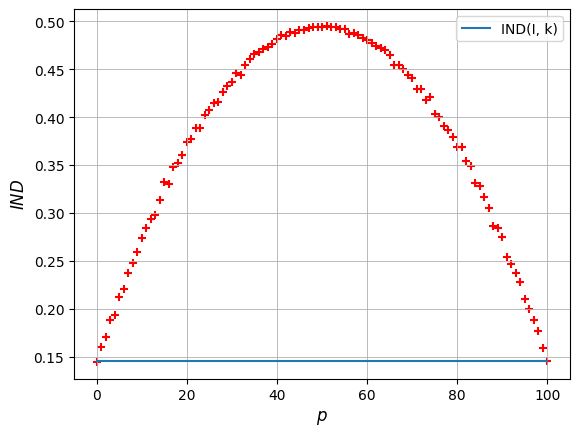

In [12]:
img_2col = cv2.imread("/content/drive/MyDrive/ittp/ittp_2col.png", cv2.IMREAD_GRAYSCALE)

index_2color_noise(img_2col, 10)

# Проверка корректности индекса структурированности на датасете ч/б изображений

Датасет содержит черно-белые изображения размера $400 \times 400$. Напишем функцию загрузки изображений с диска

In [13]:
#подключаем необходимые библиотеки и функции

import os

#чтение изображений из папки

def read_images_from_folder(folder, count):
  images = []
  i = 0
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
      images.append(img)
    i += 1
    if (i >= count):
      break
  return images

Напишем функцию добавления шума на изображение


In [14]:
#функция добавления шума согласно определению, param - вероятность того, что цвет останется прежним

def add_noise(img, param):
  height, width = img.shape
  out = np.zeros(img.shape)
  for i in range(height):
    for j in range(width):
      p = random.randint(1, 100)
      if (p <= param):
        out[i, j] = img[i, j]
      else:
        d = random.randint(1, 255)
        r = (img[i, j] + d) % 256
        out[i, j] = r
  return out.astype(np.uint8)

Загрузим изображения с диска и уменьшим их до размера $50 \times 50$ (для ускорения вычислений)

In [15]:
#загружаем изображения

images = read_images_from_folder('/content/drive/MyDrive/ittp_data_set/train_black', 1000)

#уменьшаем их размер

def resize(images, new_height, new_width):
  new_shape = (new_height, new_width)
  out = []
  for img in images:
    out.append(cv2.resize(img, new_shape, interpolation = cv2.INTER_LINEAR))
  return out

images_size50 = resize(images, 50, 50)

Для всех изображений в массиве сравним индекс для зашумленного и оригинала. Если для оригинала индекс меньше, тест пройден.

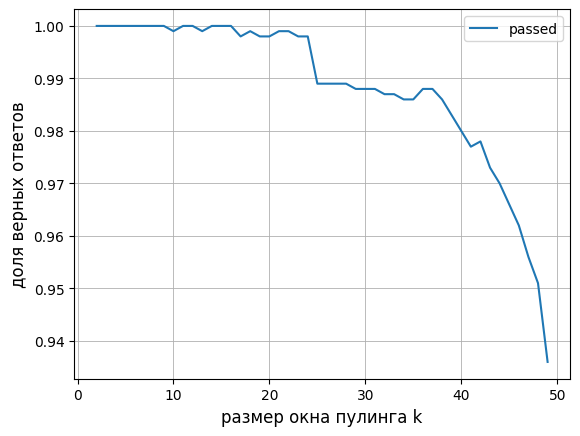

In [19]:
def first_test(images, max_pool_size, noise_param, metric_param):

  pool_size = [x for x in range(2, max_pool_size)]
  num_of_passed = [0] * (max_pool_size - 2)

  noised_images = [add_noise(img, noise_param) for img in images]

  for i in range(len(pool_size)):
    cnt = 0
    images_index = [index(img, i + 2, metric_param) for img in images]
    noised_images_index = [index(img, i + 2, metric_param) for img in noised_images]
    for j in range(len(images)):
      if (noised_images_index[j] > images_index[j]):
        cnt += 1
    num_of_passed[i] = cnt / len(images)

  plt.grid(visible=True, linewidth=0.6)
  plt.plot(pool_size, num_of_passed, label = 'passed')
  plt.ylabel('доля верных ответов', fontsize = 12)
  plt.xlabel('размер окна пулинга k', fontsize = 12)
  plt.legend()
  plt.show()

first_test(images_size50, 50, 90, 1)

Тот же тест для разных вероятностей зашумления:

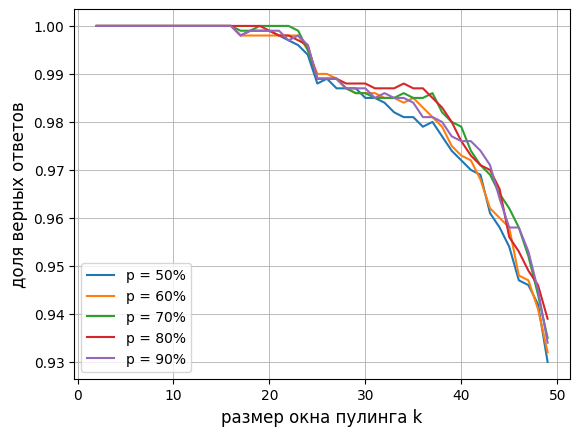

In [18]:
def second_test(images, max_pool_size, metric_param):

  for prob in range(50, 91, 10):
    pool_size = [x for x in range(2, max_pool_size)]
    num_of_passed = [0] * (max_pool_size - 2)

    noised_images = [add_noise(img, prob) for img in images]

    for i in range(len(pool_size)):
      cnt = 0
      images_index = [index(img, i + 2, metric_param) for img in images]
      noised_images_index = [index(img, i + 2, metric_param) for img in noised_images]
      for j in range(len(images)):
        if (noised_images_index[j] > images_index[j]):
          cnt += 1
      num_of_passed[i] = cnt / len(images)
    plt.plot(pool_size, num_of_passed, label = 'p = ' + str(prob) + '%')

  plt.grid(visible=True, linewidth=0.6)
  plt.ylabel('доля верных ответов', fontsize = 12)
  plt.xlabel('размер окна пулинга k', fontsize = 12)
  plt.legend()
  plt.show()

second_test(images_size50, 50, 1)

Создадим массив зашумленных изображений. Для всех изображений в исходном массиве сравним индекс для зашумленного и оригинала. Если для оригинала индекс меньше, тест пройден.

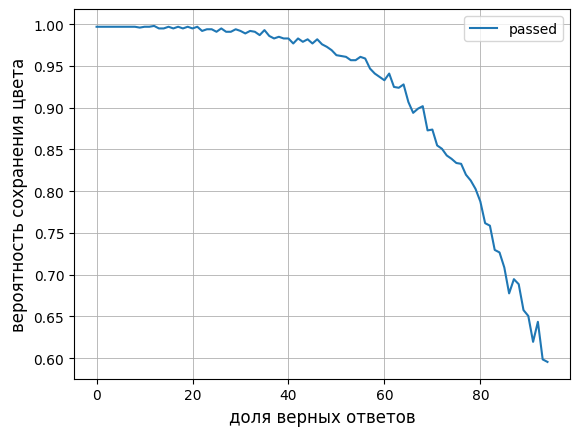

In [21]:
def third_test(images, pool_param, metric_param):

  #noise_param - процент не-зашумления в массиве

  noise_param = [x for x in range(0, 95)]
  num_of_passed = [0] * len(noise_param)

  #подсчет числа пройденых тестов при случайном выборе изображений

  images_index = [index(img, pool_param, metric_param) for img in images]

  for i in range(len(noise_param)):
    cnt = 0
    noised_images = [add_noise(img, noise_param[i]) for img in images]
    noised_images_index = [index(img, pool_param, metric_param) for img in noised_images]
    for j in range(len(images)):
      ind_noised = random.choice(noised_images_index)
      if (ind_noised > images_index[j]):
        cnt += 1
    num_of_passed[i] = cnt / len(images)

  plt.grid(visible=True, linewidth=0.6)
  plt.plot(noise_param, num_of_passed, label = 'passed')
  plt.ylabel('вероятность сохранения цвета', fontsize = 12)
  plt.xlabel('доля верных ответов', fontsize = 12)
  plt.legend()
  plt.show()

third_test(images_size50, 15, 1)